# Self-consistent solution of $\kappa-sech^2$-type electron hole

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

## sech2分布
$$ f_u(w>0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left[ 1 + \frac{(\pm \sqrt{2w}+u)^2}{\kappa\theta^2} \right]^{-\kappa} $$
$$ N_\kappa = \frac{n_\infty \Gamma(\kappa)}{\Gamma(\kappa-1/2)} $$
$$ f_t(w<0) = \frac{N_\kappa}{\sqrt{\pi\kappa\theta^2}} \left( 1 - \frac{u^2}{\kappa\theta^2} \right)^{-\kappa} 
              \left[ 1-W \frac{2\kappa}{\kappa \theta^2 + u^2} 
                      \left(   1-\frac{2(\kappa+1)u^2}{\kappa\theta^2+u^2}  \right)
              \right]$$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = \frac{2n_\infty}{\theta^2} \left[ 1 -\frac{1}{2\kappa} + \frac{u}{\theta} Z_\kappa\left(\frac{u}{\theta}\right) \right] $$
$$ D_s = \frac{n_\infty (\kappa+1/2)(\kappa-1/2)}{\theta^4 \kappa^2 (\kappa+2)} 
            \left\{ _2F_1\left[2,2\kappa+3;\kappa+3;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            + i \frac{\kappa+3/2}{\sqrt{\kappa}(\kappa+3)}\frac{u}{\theta} {}_2F_1\left[3,2\kappa+4;\kappa+4;\frac{1}{2}(1+\frac{i}{\sqrt{\kappa}}\frac{u}{\theta})\right]
            \right\}$$
$$ \theta = \sqrt{ \frac{\kappa-3/2}{\kappa} \frac{2T}{m} } $$

In [3]:
import mpmath as mp
mp.dps=10

def Un_nonvec(u,kappa,n):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac1= (1j/2)**(n+1)
    fac2= np.math.factorial(n)*sp.gamma(2*kappa+n)*sp.gamma(kappa+1)/kappa**(1.5+n/2)/sp.gamma(2*kappa-1)/sp.gamma(kappa+1+n)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(1+n,2*kappa+n,kappa+1+n,z))
    return (fac1*fac2*hyp).real

def B_kappa_nonvec(u,kappa):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = (kappa-0.5) / kappa / (kappa+1.0)
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(2,2*kappa+1,kappa+2,z))
    return 1.0/theta**2*fac*hyp.real

def D_kappa_nonvec(u,kappa):
    theta = np.sqrt(2.0-3.0/kappa)
    zeta = u/theta
    fac = 1.5 * (kappa-0.5) * (kappa+0.5) / kappa**2 / (kappa+2.0) / (kappa+3.0) / theta**4
    z = 0.5*(1.0+1j*zeta/np.sqrt(kappa))
    hyp = np.complex128(mp.hyp2f1(4,2*kappa+3,kappa+4,z))
    return fac*hyp.real

Un = np.vectorize(Un_nonvec)
B_kappa = np.vectorize(B_kappa_nonvec)
D_kappa = np.vectorize(D_kappa_nonvec)

In [4]:
u = 1.0
kappa = 8

psi = 0.001
delta = 15
theta = np.sqrt(2.0-3.0/kappa)
    
dft_dx = (4.0/delta**2 - B_kappa(u,kappa))/np.pi
d3ft_dx3 = 4*(-6.0/psi/delta**2 - D_kappa(u,kappa))/np.pi

print('dft_dx',dft_dx)
print('d3ft_dx3',d3ft_dx3)

dft_dx -0.05540414390243028
d3ft_dx3 -33.589217672847326


In [5]:
T = 1
L = 6*delta

vmax = 15 # 速度最大值
nx = 2000
nv = 140000
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

In [6]:
xp = (x-L/2)/delta
phi = 0.9*psi*np.cosh(xp)**(-2)
c1 = 0.0
c2 = 0.0
# c1 = phi[0]
# c2 = phi[-1]

In [7]:
@nb.jit
def nonvec_f_fun_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    kt2 = kappa*theta**2
    fac = math.gamma(kappa)/math.gamma(kappa-0.5)/(math.pi*kt2)**0.5
    if w>0:
        if v_waveframe<=-(2*phi)**0.5:
            r=fac*(1+(-(2*w)**0.5+u)**2/kt2)**(-kappa)
        elif v_waveframe>(2*phi)**0.5:
            r=fac*(1+( (2*w)**0.5+u)**2/kt2)**(-kappa)
    else:
        r=fac*(1+u**2/kt2)**(-kappa) * (1-w * (2*kappa/(kt2+u**2)) * (1-2*(kappa+1)*u**2/(kt2+u**2)) ) + dft_dx*(-2*w)**0.5 + d3ft_dx3*(-2*w)**1.5/6
    return r
f_fun_sech2 = np.vectorize(nonvec_f_fun_sech2)

In [9]:
err = 0.0
for count in tqdm(range(6)):
    V,Phi=np.meshgrid(v,phi)
    f_matrix = f_fun_sech2(V,Phi)
    n_vector = f_matrix.sum(axis=1)*dv
    
    dx2 = dx*dx
    laplace = -2.0*np.eye(nx-2,k=0)+np.eye(nx-2,k=1)+np.eye(nx-2,k=-1)
    r = (1.0 - n_vector[1:nx-1])*dx2 + np.dot(laplace,phi[1:nx-1])
    
    # Dirichlet BC phi[0]=c1 phi[-1]=c2
    r[0]  += c1
    r[-1] += c2
    
    m = 2.0 + (n_vector[2:nx]-n_vector[0:nx-2])/(phi[2:nx]-phi[0:nx-2])*dx2
    nr_mat = np.diag(m) - np.eye(nx-2,k=1) - np.eye(nx-2,k=-1)
    dphi = np.linalg.solve(nr_mat,r)
    phi[1:nx-1] += dphi
    
    err = ((dphi/phi[1:nx-1])**2).sum()
    print(err)
    if err<= 1e-6:
        print("Sucess! Iteration counts =", count)
        break

 17%|█████████████▊                                                                     | 1/6 [04:20<21:41, 260.29s/it]

17497.5237939648


 33%|███████████████████████████▋                                                       | 2/6 [08:38<17:15, 258.81s/it]

0.32256487374931625


 50%|█████████████████████████████████████████▌                                         | 3/6 [13:01<13:02, 260.98s/it]

5.308893868024002e-06


 50%|█████████████████████████████████████████▌                                         | 3/6 [17:18<17:18, 346.27s/it]

7.44855186309078e-08
Sucess! Iteration counts = 3


In [10]:
phi_theo = psi*np.cosh((x-L/2)/delta)**(-2)
n_theo = 1+(4*phi_theo - 6*phi_theo**2/psi)/delta**2

In [11]:
V,Phi=np.meshgrid(v,phi)
V,Phi_theo=np.meshgrid(v,phi_theo)
f_matrix = f_fun_sech2(V,Phi)
f_matrix_th = f_fun_sech2(V,Phi_theo)
fv = f_matrix.sum(axis=0)*dx/L
fv_th = f_matrix_th.sum(axis=0)*dx/L

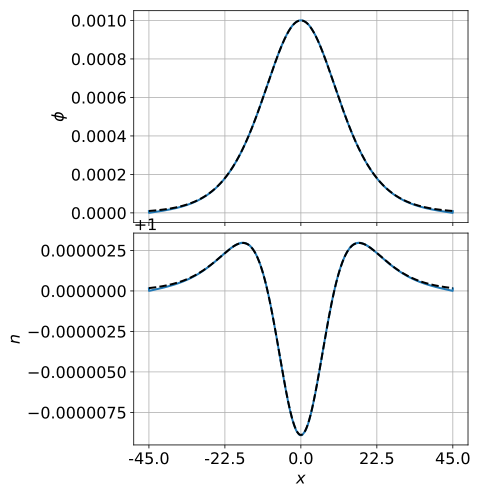

In [11]:
xticks = np.linspace(0,L,num=5)
xticks_show = np.linspace(-L/2,L/2,num=5)

fig = plt.figure(figsize=(6,8))

ax1 = plt.subplot(211)
ax1.plot(x,phi)
ax1.plot(x,phi_theo,color='black',linestyle='--')
ax1.grid()
plt.xticks(xticks,())
ax1.set_ylabel(r'$\phi$')

ax2 = plt.subplot(212)
ax2.plot(x,n_vector)
ax2.plot(x,n_theo,color='black',linestyle='--')
ax2.grid()
plt.xticks(xticks,xticks_show)
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$n$')

plt.subplots_adjust(hspace = 0.05,wspace=0.1)
# plt.savefig('../1-submit to pop/1-resubmission/verification_psi_n.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (140000,) and (70000,)

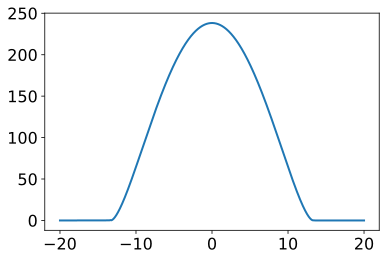

In [30]:
plt.plot(v,f_matrix[int(nx/2),])
plt.plot(v,f_matrix_th[int(nx/2),],color='black',linestyle='--')
plt.xlim(-3*theta,3*theta)
plt.xlabel(r'$v$')
plt.ylabel(r'$f_0$')
plt.grid()

# plt.savefig('../1-submit to pop/1-resubmission/verification_fv.pdf',dpi=600,bbox_inches = 'tight')
plt.show()

In [12]:
def phi2_theo(x,a,da):
    xp = (x-L/2)/da
    return a*np.cosh(xp)**(-2)

from scipy.optimize import curve_fit
para2,pcov=curve_fit(phi2_theo,x,phi)
Ddelta = round(abs(para2[1]-delta)/para2[1]*100,2)
Dpsi = round(abs(para2[0]-psi)/para2[0]*100,2)  

print('sech2 fit:',para2)
print('Dpsi     :',Dpsi,'%')
print('Ddelta   :',Ddelta,'%')

sech2 fit: [1.00155583e-03 1.49549201e+01]
Dpsi     : 0.16 %
Ddelta   : 0.3 %


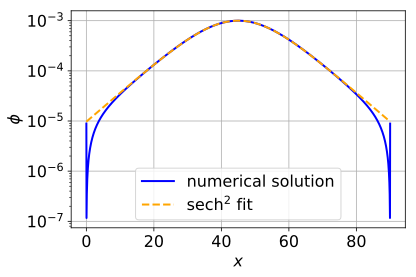

In [13]:
fig = plt.figure(figsize=(6,4))
plt.plot(x,phi,color='blue',label=r'numerical solution')
plt.plot(x,phi2_theo(x,para2[0],para2[1]),'--',color='orange',label=r'$\mathrm{sech}^2$ fit')
plt.xlabel(r'$x$')
plt.ylabel(r'$\phi$')
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()